<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/classifier_binary_fp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet
!rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet

Test classifier works on JAK1 dataset

In [82]:
! pip install pubchempy --quiet
! pip install rdkit --quiet

In [83]:
import pandas as pd
from JAK_ML.ML_code.function import *

data = pd.read_csv('JAK_ML/new_data/JAK1_final.csv')
data.head()

,Unnamed: 0,Smiles,Activity
0,0,COCCOC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc...,1
1,1,CC(C)COC1CCCN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3nc...,1
2,2,C[C@H]1CN(S(=O)(=O)C[C@H]2CC[C@H](N(C)c3ncnc4[...,1
3,3,C[C@@H]1C[C@@H](CS(=O)(=O)N2CC[C@H](CO)C2)CC[C...,1
4,4,CN(c1ncnc2[nH]ccc12)[C@H]1CC[C@H](CS(=O)(=O)N2...,1


In [84]:
from sklearn.model_selection import train_test_split

MACCS_list = smile_list_to_MACCS(data['Smiles'].tolist())
header = ['bit' + str(i) for i in range(167)]
df = pd.DataFrame(MACCS_list, columns = header)
df['Activity'] = data['Activity']

train, test = train_test_split(df, test_size=0.2)

print('train, test shape: ', train.shape, test.shape)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train, test shape:  (5898, 168) (1475, 168)


In [85]:
from a_inhibitor_design.model.evaluate_utils import get_min, plot_loss
from a_inhibitor_design.model.classifier_binary import \
Classifier_binary, fp_dataset

In [86]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.nn import init

train_dataset = fp_dataset(train)
test_dataset = fp_dataset(test)

params = {'batch_size': 16, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

In [87]:
in_dim = 167
hid_dims = [256, 64]
out_dim = 1

model = Classifier_binary([in_dim, hid_dims])
cuda = torch.cuda.is_available()

if cuda: model = model.cuda()
optimizer = optim.AdamW(params=model.parameters(), lr=1e-2, weight_decay=1e-2)
loss_function = nn.BCELoss()

epoch 0: 100%|██████████| 369/369 [00:54<00:00,  6.75it/s]


[Train] loss: 0.331
[Test] loss: 0.290


epoch 1: 100%|██████████| 369/369 [00:49<00:00,  7.52it/s]


[Train] loss: 0.251
[Test] loss: 0.241


epoch 2: 100%|██████████| 369/369 [00:46<00:00,  7.94it/s]


[Train] loss: 0.223
[Test] loss: 0.231


epoch 3: 100%|██████████| 369/369 [00:46<00:00,  8.00it/s]


[Train] loss: 0.198
[Test] loss: 0.227


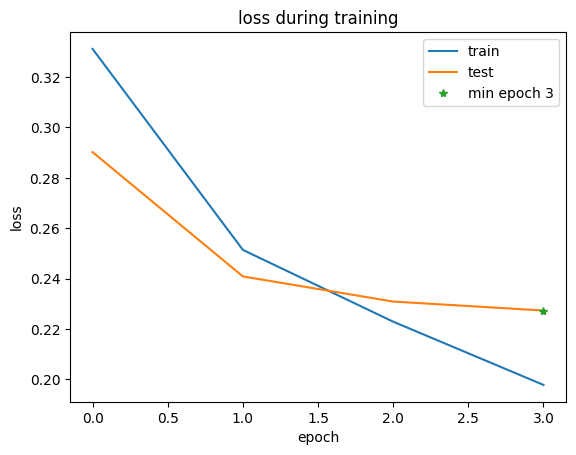

epoch 4: 100%|██████████| 369/369 [00:46<00:00,  7.94it/s]


[Train] loss: 0.178
[Test] loss: 0.220


epoch 5: 100%|██████████| 369/369 [00:44<00:00,  8.30it/s]


[Train] loss: 0.169
[Test] loss: 0.234


epoch 6: 100%|██████████| 369/369 [00:47<00:00,  7.83it/s]


[Train] loss: 0.161
[Test] loss: 0.258


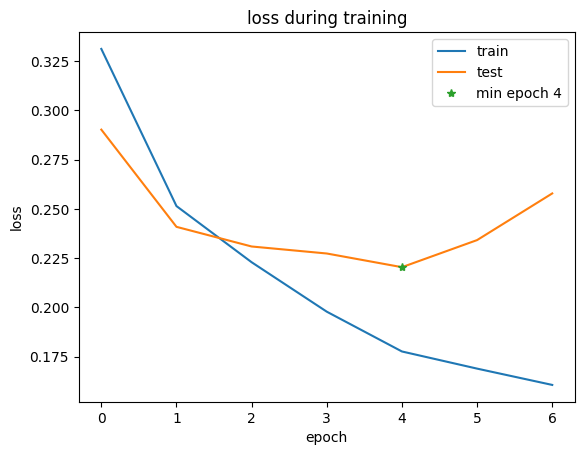

epoch 7: 100%|██████████| 369/369 [00:45<00:00,  8.02it/s]


[Train] loss: 0.150
[Test] loss: 0.210
Get current working directory :  /content
model saved at:  test_7.pt


epoch 8: 100%|██████████| 369/369 [00:45<00:00,  8.06it/s]


[Train] loss: 0.144
[Test] loss: 0.225


epoch 9: 100%|██████████| 369/369 [00:44<00:00,  8.21it/s]


[Train] loss: 0.139
[Test] loss: 0.211


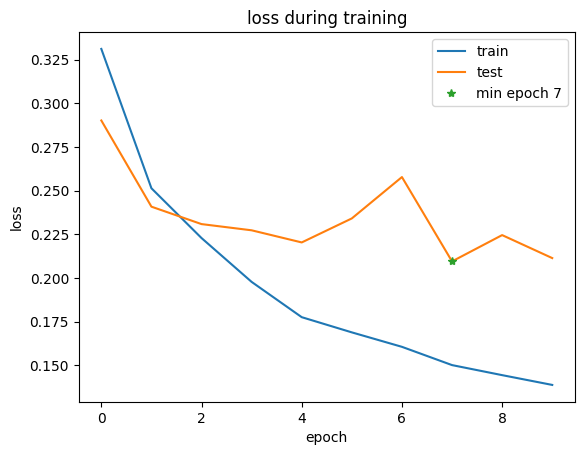

epoch 10: 100%|██████████| 369/369 [00:45<00:00,  8.16it/s]


[Train] loss: 0.134
[Test] loss: 0.194
Get current working directory :  /content
model saved at:  test_10.pt


epoch 11: 100%|██████████| 369/369 [00:50<00:00,  7.32it/s]


[Train] loss: 0.133
[Test] loss: 0.192
Get current working directory :  /content
model saved at:  test_11.pt


epoch 12: 100%|██████████| 369/369 [00:47<00:00,  7.83it/s]


[Train] loss: 0.122
[Test] loss: 0.260


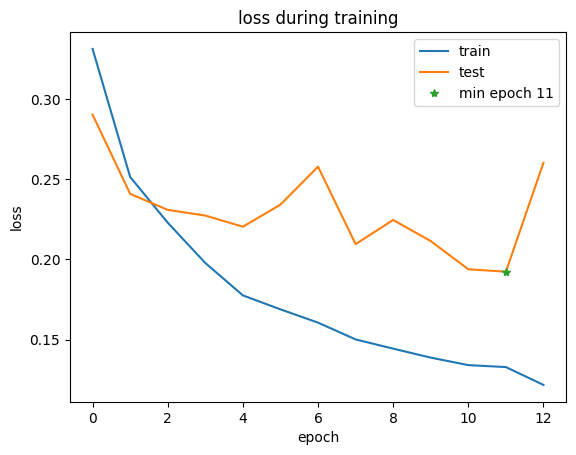

early stop, large loss increase


In [41]:
epochs = 30

train_loss_dict = {}
test_loss_dict = {}

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i, (fp, label) in tqdm(enumerate(train_loader),
        total=len(train_loader), desc=f'epoch {epoch}'):

        optimizer.zero_grad()
        if cuda: fp, label = fp.float().cuda(), label.cuda()

        output = model(fp)
        if output.dtype != label.dtype:
            label = label.type(output.dtype)

        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader)
    print(f'[Train] loss: {total_loss:.3f}')
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_test_loss = 0
    for i, (fp, label) in enumerate(test_loader):

        if torch.cuda.is_available():
            fp, label = fp.float().cuda(), label.cuda()

        output = model(fp)
        label = label.type(output.dtype)
        loss = loss_function(output, label)
        total_test_loss += loss.item()

    total_test_loss /= len(test_loader)

    print(f'[Test]  loss: {total_test_loss:.3f}')
    test_loss_dict[epoch] = total_test_loss

    if epoch % 3 == 0 and epoch != 0:
        plot_loss(train_loss_dict, test_loss_dict)

    argmin, min_loss = get_min(test_loss_dict)
    if test_loss_dict[epoch] <= min_loss and epoch > 3:
        torch.save(model.state_dict(), f'test_{str(epoch)}.pt')
        print('Get current working directory : ', os.getcwd())
        print('model saved at: ', f'test_{str(epoch)}.pt')
    else:
        if epoch - argmin > 10:
            print('early stop, no decrease')
            break
        if test_loss_dict[epoch] / min_loss > 1.3:
            print('early stop, large loss increase')
            break

In [80]:
def thres(t:torch.Tensor, prob=0.5):
    preds = []
    probs = []
    for i in t.cpu().detach().numpy():
        i = i[0]
        # print(type(i))
        # assert(isinstance(i, float))
        probs.append(i)
        if i > prob: preds.append(1)
        else: preds.append(0)
        # print(i[0])
    return probs, preds

# thres(output)

In [ ]:
model_ = Classifier_binary([in_dim, hid_dims])
cuda = torch.cuda.is_available()

model_path = '/content/test_11.pt'
if cuda: model_ = model_.cuda()
model_.load_state_dict(
            torch.load(model_path, map_location='cuda'))

y_preds = []
y_trues = []
y_probs = []

for i, (fp, label) in enumerate(test_loader):

    if torch.cuda.is_available():
        fp, label = fp.float().cuda(), label.cuda()

    output = model_(fp)
    label = label.type(output.dtype)
    loss = loss_function(output, label)
    total_test_loss += loss.item()
    probs, preds = thres(output)
    y_probs.extend(probs)
    y_preds.extend(preds)
    y_trues.extend(label.view(label.shape[0]).tolist())
evaluate(y_trues, y_preds, y_probs)